In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from NeuralNetworks import *
from numerical_integration import *
from tqdm import tqdm
from Kepler import *
from Training_general import *
torch.set_default_dtype(torch.float32)

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [2]:
def initial_condition():
        def sampler():
            while True:
                H0 = np.random.uniform(-1.5,-1e-3)
                e = np.random.uniform(0.1,0.7)
                a = -1/(2*H0)
                L0 = np.sqrt((e**2-1)/(2*H0))

                x0, y0 = a * (1 - e), 0
                px0 = 0
                py0 = L0/x0

                if py0 > 2.0:
                    continue
                if L0 > 1.0:
                    continue
                
                H = 0.5 * (px0**2 + py0**2) - 1 / np.sqrt(x0**2 + y0**2)
                if np.isclose(H, H0,atol=1e-6): 
                    break
            return np.array([x0, y0, px0, py0]).flatten()
        return sampler()
    

In [3]:
def initial_condition():
        def sampler():
            while True:
                H0 = np.random.uniform(-1.5, -0.01)
                e = np.random.uniform(0.1, 0.7)
                a = -1 / (2 * H0)

                L0 = np.sqrt((e**2 - 1) / (2 * H0))
                if L0 > 1.0:
                    continue

                theta = np.random.uniform(0, 2*np.pi)
                r = a * (1 - e**2) / (1 + e * np.cos(theta))

                x0 = r * np.cos(theta)
                y0 = r * np.sin(theta)

                v = np.sqrt(2 * (1/r + H0))
                vx_dir = -np.sin(theta)
                vy_dir = np.cos(theta)

                px0 = v * vx_dir
                py0 = v * vy_dir

                # Optional: rotate whole orbit
                angle = np.random.uniform(0, 2*np.pi)
                R = np.array([
                    [np.cos(angle), -np.sin(angle)],
                    [np.sin(angle),  np.cos(angle)]
                ])
                x0, y0 = R @ np.array([x0, y0])
                px0, py0 = R @ np.array([px0, py0])

                # Check Hamiltonian consistency
                H = 0.5 * (px0**2 + py0**2) - 1 / np.sqrt(x0**2 + y0**2)
                if np.isclose(H, H0, atol=1e-5):
                    return np.array([x0, y0, px0, py0])
        return sampler()
    

In [4]:
T_max_train = 2*np.pi
nsamples_train = 100*T_max_train/2
ntraj_train = 1750#int(3000*0.75)
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750#int(3000*0.25)

sys = KeplerSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

act_1 = PAU()
act_2 = nn.Softplus()

epochs = 100
batch_size = 64 
lr = 1e-3

lam=1e-3 #Coeffcient for angular momentum conservation in loss

In [13]:
T_max_train = 5
nsamples_train = 100*5
ntraj_train = int(3000*0.75)
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = int(3000*0.25)


sys = KeplerSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

act_1 = PAU()
act_2 = nn.Softplus()

epochs = 100
batch_size = 256
lr = 1e-3

lam=1e-3 #Coeffcient for angular momentum conservation in loss


In [6]:
def Kepler_loss_func(dudt,dudt_est,u,sys,lam=lam):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    if lam == 0:
        return MSE_dudt
    else:
        if u.ndim ==1:
            x,y,px,py = u[0],u[1],u[2],u[3]
            x_dot,y_dot,px_dot,py_dot = dudt_est[0],dudt_est[1],dudt_est[2],dudt_est[3]
        else:
            x,y,px,py = u[:,0],u[:,1],u[:,2],u[:,3]
            x_dot,y_dot,px_dot,py_dot = dudt_est[:,0],dudt_est[:,1],dudt_est[:,2],dudt_est[:,3]
        dLdt_est = py*x_dot-px*y_dot-y*px_dot+x*py_dot
        dLdt = torch.stack([sys.L_dot(u_i) for u_i in u])
        MSE_dLdt = func(dLdt_est,dLdt)
        loss = MSE_dudt + lam*MSE_dLdt
        return loss

loss_func = loss_wrapper(Kepler_loss_func)


### Symplectic Euler

In [7]:
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train, integrator=integrator)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

100%|██████████| 750/750 [00:00<00:00, 754.68it/s]


In [ ]:
model_symp_eul = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp_eul = torch.optim.Adam(model_symp_eul.parameters(), lr=lr)


model_symp_eul, trainingdetails_symp_eul = train(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul,shuffle=True,loss_func = Kepler_loss_func, system = sys,batch_size = batch_size, epochs = epochs, L_coeff = lam)
#model_symp_eul, trainingdetails_symp_eul = train(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul,shuffle=True,batch_size = batch_size, epochs = epochs, name_sys = "Kepler")

In [5]:
def load_model(path):
    checkpoint = torch.load(path,weights_only=False)
    model = checkpoint['model'] 
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, epoch, loss

model_symp_eul, trainingdetails_symp_eul, loss =load_model("Models/Kepler_symplectic euler_100epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_256_shape_torch.Size([256, 4])_L_coeff_0.001.pt")

In [ ]:
tmax = 1*3
nsamples = 100*3
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp_eul.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)
print("u0: ",u0s)
H0 = sys.Hamiltonian(u0s.squeeze(0))
L0 = sys.Angular_Momentum(u0s)
print("H0: ", H0)
print("L0: ", L0)

e = np.sqrt(1+2*H0*L0**2)

print("e: ", e)


fig, ax = plt.subplots(1, 4, figsize=(20, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Euler" )
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])
L_exact = torch.tensor([sys.Angular_Momentum(u) for u in u_exact.squeeze(0)])

C =model_symp_eul.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))


t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp_eul.Hamiltonian(u)- C)for u in u_samples])
L_symp_nn= torch.tensor([( np.sqrt((e**2-1)/(2*H)))for H in H_symp_nn])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
L_exact_pred = torch.tensor([sys.Angular_Momentum(u) for u in u_samples])
#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp_eul.Hamiltonian(torch.tensor(u, dtype = torch.float32)) -C) for u in u_exact.squeeze(0)])
L_nn_exact= torch.tensor([( np.sqrt((e**2-1)/(2*H)))for H in H_nn_exact])

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Euler")
ax[1].legend()

ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Euler")
ax[2].legend()

ax[3].plot(t, L_exact, label="L(u)")
ax[3].plot(t, L_symp_nn, label=r"$\hat{L}_{\theta}(\hat u)$")
ax[3].plot(t, L_exact_pred, label=r"$L(\hat u)$")
ax[3].plot(t, L_nn_exact, label=r"$\hat{L}_{\theta}(u)$")
ax[3].set_xlabel("Time")
ax[3].set_ylabel("L")
ax[3].set_title("Angular Momentum Symplectic Euler")
ax[3].legend()

plt.tight_layout() 
plt.show()



In [ ]:

i = (H_exact_pred == min(H_exact_pred)).nonzero(as_tuple=True)[0]
tmax* int(i)/nsamples

## Symplectic Midpoint

In [14]:
integrator = "symplectic midpoint"
(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator,u0s= u0s_train)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

100%|██████████| 750/750 [00:42<00:00, 17.49it/s]


100%|██████████| 100/100 [1:54:09<00:00, 68.49s/it, epoch=99, loss=0.000536]   


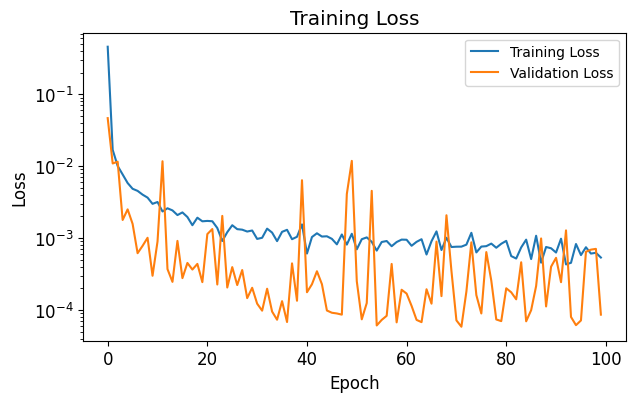

In [15]:

model_symp = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)
optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)

model_symp, trainingdetails_symp = train(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp,shuffle=True,loss_func = loss_func, system = sys,batch_size = batch_size, epochs = epochs)
#model_symp, trainingdetails_symp = train(model = model_symp,integrator = integrator, train_data = train_data ,val_data = val_data,optimizer = optimizer_symp,shuffle=True, epochs = epochs)


In [16]:

#model_symp, trainingdetails_symp, loss =load_model("Models/Kepler_symplectic midpoint_100epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_256_shape_torch.Size([225000, 4])_L_coeff_0.pt")

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


tensor([[7.6696]], grad_fn=<SubBackward0>)


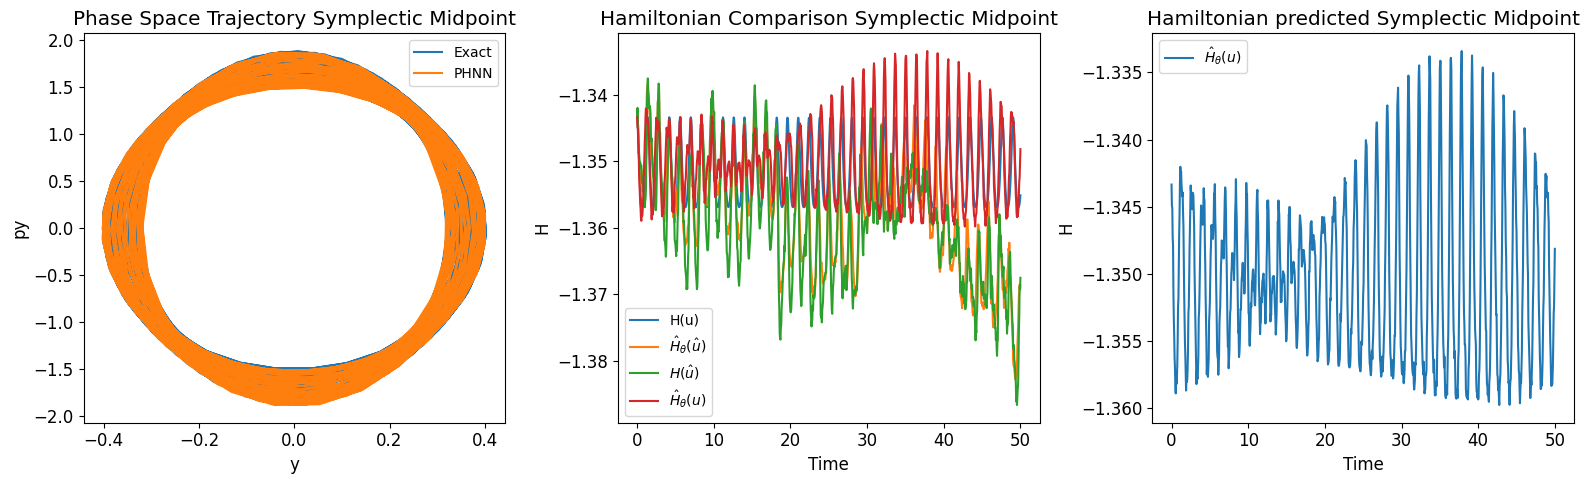

In [30]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples


nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Midpoint")
ax[0].legend()

C =model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))

H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])
t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp.Hamiltonian(u) -C)for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32))-C) for u in u_exact.squeeze(0)])

print(C)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred,  label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Midpoint")
ax[1].legend()



ax[2].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()

tensor([[7.6681]], grad_fn=<SubBackward0>)


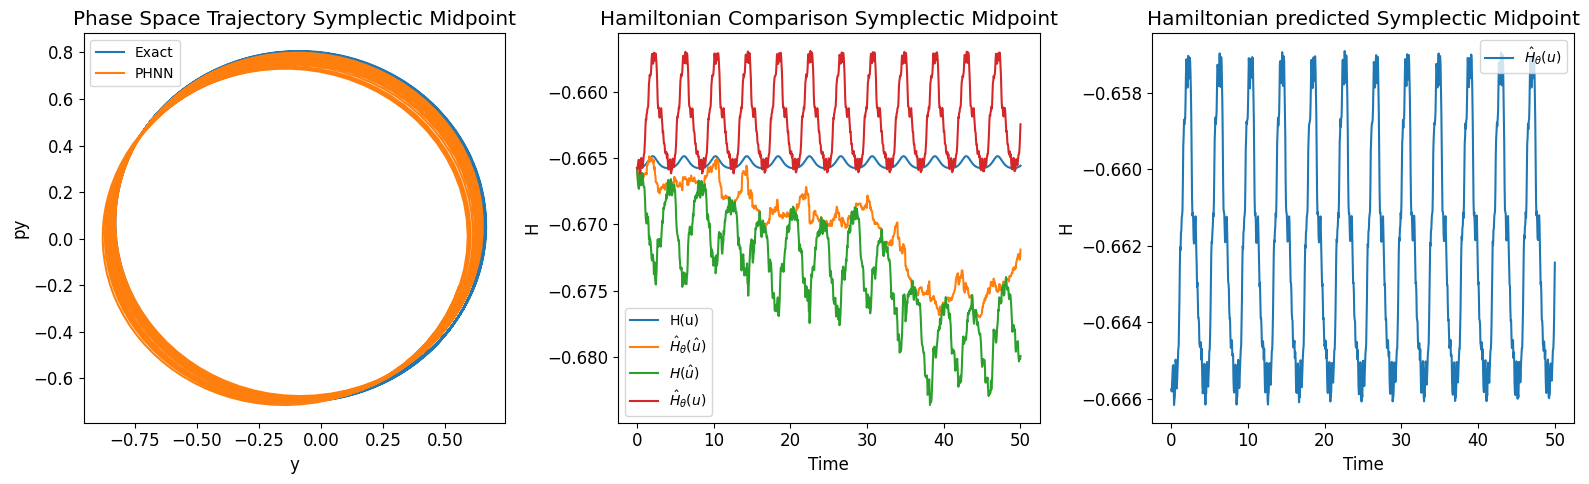

In [18]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 0], u_exact[0][:, 1]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 0], u_phnn_symp[0][:, 1]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Midpoint")
ax[0].legend()

C =model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))

H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])
t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp.Hamiltonian(u) -C)for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32))-C) for u in u_exact.squeeze(0)])

print(C)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred,  label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Midpoint")
ax[1].legend()



ax[2].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()

In [19]:
import torch

def find_pericenter(trajectory):
    """
    Find the (x, y) position of pericenter from a trajectory.

    Args:
        trajectory: Tensor of shape [N, 4], columns are [x, y, px, py]

    Returns:
        (x_peri, y_peri): Coordinates of pericenter
    """
    r = trajectory[:, :2]     # [x, y]
    p = trajectory[:, 2:]     # [px, py]

    # Compute radial velocity: dot(r, p)
    radial_velocity = torch.sum(r * p, dim=1)

    # Find zero-crossings (radial velocity changes from negative to positive)
    sign_changes = (radial_velocity[:-1] * radial_velocity[1:]) < 0

    if torch.any(sign_changes):
        first_crossing = torch.where(sign_changes)[0][0]
        # Interpolate for smoother result
        i = first_crossing
        r1, r2 = r[i], r[i+1]
        rv1, rv2 = radial_velocity[i], radial_velocity[i+1]
        alpha = -rv1 / (rv2 - rv1)
        peri_pos = r1 + alpha * (r2 - r1)
    else:
        # fallback: just return point with minimal distance to origin
        distances = torch.norm(r, dim=1)
        min_idx = torch.argmin(distances)
        peri_pos = r[min_idx]

    return peri_pos[0].item(), peri_pos[1].item()

import numpy as np
import torch

def find_closest_index_to_pericenter(trajectory, x_peri, y_peri):
    """
    Given a trajectory and a pericenter position (x_peri, y_peri),
    return the index of the closest (x, y) point in the trajectory.

    Args:
        trajectory: array or tensor of shape [N, 4], with columns [x, y, px, py]
        x_peri, y_peri: coordinates of pericenter

    Returns:
        index: integer index of the closest point
    """
    # Convert to torch if it's a numpy array
    if isinstance(trajectory, np.ndarray):
        trajectory = torch.tensor(trajectory, dtype=torch.float32)

    xy = trajectory[:, :2]  # only x, y
    peri_point = torch.tensor([x_peri, y_peri], dtype=torch.float32)

    distances = torch.norm(xy - peri_point, dim=1)
    index = torch.argmin(distances)

    return index.item()

# Fake trajectory [x, y, px, py] shape: [1000, 4]
trajectory = torch.tensor(u_exact[0], dtype=torch.float32)

x_peri, y_peri = find_pericenter(trajectory)
print("Pericenter at:", x_peri, y_peri)

idx = find_closest_index_to_pericenter(trajectory, x_peri, y_peri)
print(f"Closest point to pericenter is at index: {idx}")



Pericenter at: -0.6776540279388428 0.5172392725944519
Closest point to pericenter is at index: 0


In [20]:
u_exact[0][251]

array([-0.81804721,  0.21126988, -0.20289758, -0.99726009])

In [21]:
def learned_adjusted(u):
    C =model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))
    return torch.tensor([model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32))-C])
def dH_adjusted(u):

SyntaxError: incomplete input (3892686819.py, line 4)

In [ ]:
u_phnn_symp[0][251]

tensor([-0.5613,  0.0028, -0.0755, -1.2667])

In [ ]:
950/nsamples * tmax

47.5

In [ ]:
u_phnn_symp[0][950:1001]

tensor([[-7.8407e-01, -1.2347e+00,  2.4554e-01, -3.0138e-01],
        [-7.7742e-01, -1.2490e+00,  2.5826e-01, -2.6969e-01],
        [-7.7020e-01, -1.2615e+00,  2.7064e-01, -2.3786e-01],
        [-7.6227e-01, -1.2722e+00,  2.8283e-01, -2.0592e-01],
        [-7.5369e-01, -1.2812e+00,  2.9485e-01, -1.7381e-01],
        [-7.4435e-01, -1.2883e+00,  3.0680e-01, -1.4152e-01],
        [-7.3425e-01, -1.2936e+00,  3.1876e-01, -1.0897e-01],
        [-7.2343e-01, -1.2972e+00,  3.3078e-01, -7.6117e-02],
        [-7.1185e-01, -1.2991e+00,  3.4291e-01, -4.2915e-02],
        [-6.9946e-01, -1.2992e+00,  3.5522e-01, -9.3359e-03],
        [-6.8621e-01, -1.2976e+00,  3.6775e-01,  2.4632e-02],
        [-6.7205e-01, -1.2941e+00,  3.8057e-01,  5.9077e-02],
        [-6.5682e-01, -1.2888e+00,  3.9370e-01,  9.3946e-02],
        [-6.4057e-01, -1.2818e+00,  4.0704e-01,  1.2926e-01],
        [-6.2325e-01, -1.2730e+00,  4.2064e-01,  1.6500e-01],
        [-6.0480e-01, -1.2624e+00,  4.3438e-01,  2.0120e-01],
        

In [ ]:
u_exact[0][950:1001]

array([[ 0.0328445 , -0.57616185,  1.22562818,  0.12728822],
       [ 0.09370897, -0.56603439,  1.20895059,  0.27781021],
       [ 0.15332603, -0.54839747,  1.17573213,  0.42766635],
       [ 0.21085701, -0.52331909,  1.12550696,  0.57546881],
       [ 0.26543966, -0.4909411 ,  1.05779899,  0.719651  ],
       [ 0.31618853, -0.4514893 ,  0.97215599,  0.85842106],
       [ 0.36219742, -0.40528591,  0.86819931,  0.98971431],
       [ 0.40254475, -0.35276436,  0.74569389,  1.11114775],
       [ 0.43630317, -0.29448612,  0.60464288,  1.21998195],
       [ 0.46255453, -0.23115909,  0.44541176,  1.31309911],
       [ 0.48041194, -0.16365637,  0.2688847 ,  1.38701013],
       [ 0.48905035, -0.0930334 ,  0.0766517 ,  1.4379087 ],
       [ 0.48774708, -0.02054081, -0.12878263,  1.46179497],
       [ 0.47593275,  0.0523714 , -0.34379038,  1.45469321],
       [ 0.45325172,  0.12406332, -0.56345086,  1.4129838 ],
       [ 0.41962849,  0.19273427, -0.7814786 ,  1.3338542 ],
       [ 0.3753335 ,  0.

## Testing

In [ ]:
u_exact
u_phnn_symp

In [ ]:
H_exact
H_symp_nn #learned of learned
H_exact_pred #analutical on learned coord
H_nn_exact  #learned on exact

#[850:1001] is 42.5 to 50 in


In [ ]:
H_exact

tensor([-0.9694, -0.9694, -0.9696,  ..., -0.9735, -0.9735, -0.9734],
       dtype=torch.float64)

In [ ]:
H_exact_pred[800:1001] 

tensor([-1.1915e+00, -1.1925e+00, -1.1938e+00, -1.1961e+00, -1.1982e+00,
        -1.2019e+00, -1.2058e+00, -1.2108e+00, -1.2090e+00, -1.1933e+00,
        -1.1660e+00, -1.1394e+00, -1.1193e+00, -1.1466e+00, -1.1497e+00,
        -1.1631e+00, -1.1670e+00, -1.1729e+00, -1.1814e+00, -1.1860e+00,
        -1.1887e+00, -1.1903e+00, -1.1894e+00, -1.1889e+00, -1.1881e+00,
        -1.1876e+00, -1.1871e+00, -1.1872e+00, -1.1877e+00, -1.1877e+00,
        -1.1875e+00, -1.1876e+00, -1.1879e+00, -1.1889e+00, -1.1909e+00,
        -1.1937e+00, -1.1986e+00, -1.2049e+00, -1.2129e+00, -1.2258e+00,
        -1.2437e+00, -1.2600e+00, -1.2305e+00, -7.8163e-01, -1.2816e-01,
        -5.2613e-01, -5.8259e-01, -6.8060e-01, -7.1306e-01, -7.1048e-01,
        -7.0979e-01, -7.1216e-01, -7.1566e-01, -7.1900e-01, -7.2201e-01,
        -7.2427e-01, -7.2587e-01, -7.2700e-01, -7.2716e-01, -7.2697e-01,
        -7.2650e-01, -7.2545e-01, -7.2407e-01, -7.2258e-01, -7.2109e-01,
        -7.1976e-01, -7.1863e-01, -7.1775e-01, -7.1

In [ ]:
H_symp_nn[800:1001] 

tensor([-1.1955, -1.1955, -1.1952, -1.1949, -1.1943, -1.1934, -1.1923, -1.1904,
        -1.1855, -1.1746, -1.1581, -1.1434, -1.1292, -1.1349, -1.1486, -1.1674,
        -1.1789, -1.1853, -1.1890, -1.1901, -1.1907, -1.1918, -1.1922, -1.1927,
        -1.1926, -1.1927, -1.1928, -1.1928, -1.1928, -1.1928, -1.1926, -1.1924,
        -1.1921, -1.1921, -1.1921, -1.1921, -1.1922, -1.1921, -1.1915, -1.1911,
        -1.1912, -1.1909, -1.1786, -0.3101, -0.1836, -0.5110, -0.6579, -0.7076,
        -0.7173, -0.7178, -0.7188, -0.7191, -0.7194, -0.7192, -0.7193, -0.7191,
        -0.7191, -0.7192, -0.7192, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191,
        -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191,
        -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191,
        -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191,
        -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7191, -0.7192, -0.7192,
        -0.7192, -0.7192, -0.7192, -0.71

In [ ]:
torch.tensor(u_exact[0][850:1001]) -u_phnn_symp[0][850:1001] 

tensor([[ 0.9679,  0.1133,  0.9678,  2.6828],
        [ 1.0076,  0.2517,  0.5741,  2.6296],
        [ 1.0281,  0.3861,  0.2163,  2.5387],
        [ 1.0316,  0.5151, -0.1117,  2.4134],
        [ 1.0197,  0.6366, -0.4123,  2.2556],
        [ 0.9939,  0.7495, -0.6854,  2.0662],
        [ 0.9554,  0.8519, -0.9296,  1.8463],
        [ 0.9059,  0.9423, -1.1417,  1.5965],
        [ 0.8471,  1.0194, -1.3176,  1.3184],
        [ 0.7810,  1.0817, -1.4517,  1.0140],
        [ 0.7094,  1.1278, -1.5372,  0.6874],
        [ 0.6352,  1.1571, -1.5666,  0.3448],
        [ 0.5612,  1.1689, -1.5321, -0.0048],
        [ 0.4906,  1.1632, -1.4271, -0.3482],
        [ 0.4270,  1.1407, -1.2480, -0.6686],
        [ 0.3741,  1.1030, -0.9965, -0.9455],
        [ 0.3353,  1.0530, -0.6819, -1.1573],
        [ 0.3130,  0.9942, -0.3223, -1.2843],
        [ 0.3089,  0.9313,  0.0562, -1.3137],
        [ 0.3232,  0.8691,  0.4232, -1.2430],
        [ 0.3547,  0.8125,  0.7489, -1.0816],
        [ 0.4007,  0.7656,  1.0104

In [ ]:
u_exact[0][100:1001]

array([[ 0.33490305,  0.11834899, -0.60755175,  1.69252415],
       [ 0.29555152,  0.19846563, -0.96650942,  1.51214155],
       [ 0.2397394 ,  0.26755489, -1.26597512,  1.25142883],
       ...,
       [-0.36277629,  0.08116702, -0.21966343, -1.71153572],
       [-0.36445726, -0.00537918,  0.15242429, -1.75031243],
       [-0.34723307, -0.09158643,  0.53654334, -1.69797739]],
      shape=(901, 4))

In [ ]:
u_phnn_symp[0][100:1001] 

tensor([[ 0.3646,  0.0162, -0.1198,  1.7551],
        [ 0.3492,  0.1027, -0.4956,  1.6926],
        [ 0.3156,  0.1838, -0.8449,  1.5416],
        ...,
        [-1.7018,  0.1125,  0.9528,  1.6811],
        [-1.6537,  0.1732,  0.9763,  1.6936],
        [-1.6052,  0.2338,  1.0001,  1.7055]])

In [ ]:

C =model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))

print(C)
print(u0s)
sys.Hamiltonian(u0s.squeeze(0))

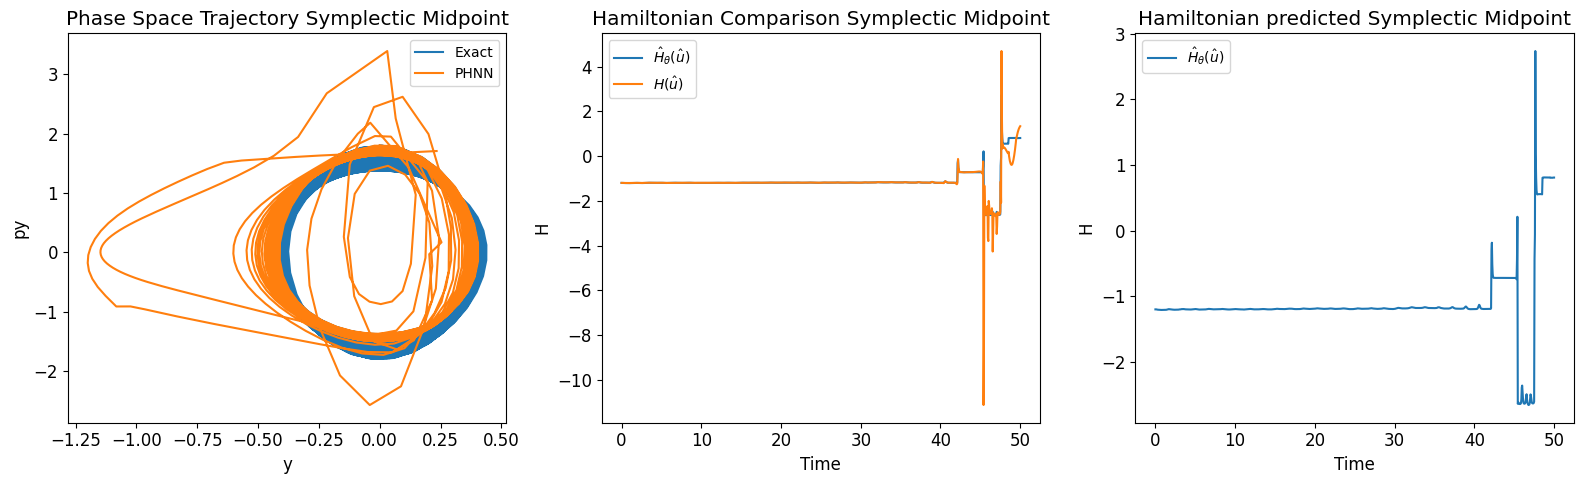

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Midpoint")
ax[0].legend()


#ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred,  label=r"$H(\hat u)$")
#ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Midpoint")
ax[1].legend()



ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()

In [ ]:
A = torch.tensor([[0, 0, 0, 1],[0, 0, -1, 0],[0, -1, 0, 0],[1, 0, 0, 0]], dtype=u_end.dtype)
dLdt = sys.L_dot(u_start)
dLdt_est = u_start@A@dudt_est 
angular_mom_loss = lam*loss_func(dLdt_est,dLdt)


def Kepler_loss_func(dudt,dudt_est,u_start,sys,lam=0):
    func = torch.nn.MSELoss()
    A = torch.tensor([[0, 0, 0, 1],[0, 0, -1, 0],[0, -1, 0, 0],[1, 0, 0, 0]], dtype=u_end.dtype)
    dLdt = sys.L_dot(u_start)
    dLdt_est = u_start@A@dudt_est 
    loss = func(dudt_est,dudt) + lam*func(dLdt_est,dLdt)
    return loss




loss_func = Kepler_loss_func
batch_size=1024
epochs = 20

train(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul,shuffle=True,loss_func = Kepler_loss_func, system = sys,batch_size = batch_size, epochs = epochs)